# Current

*  Fix the issue with the mappings in the quadratures, etc. Maybe you have to pass all the fiat_element.mapping() array around? Whatever
* Implement the trafo for the derivatives.
* Fix the hack (in particular remove the check for `isinstance(elem, CubeHermite)` in `representation.py` and generalise to 3D, etc.
* <strike>`interpolate()` does not work.</strike>
* <strike>`project()` does not work if the Expression to project has been defined using `element=W.ufl_element()`. The error is `RuntimeError: evaluate_dof(s) for enriched element not implemented.`</strike>

# Intro

See hermite.tm...

**Note** I don't understand why there is no problem with the Argyris element any more since I pulled the latest changes from branch next. Before I had the same issues as with the CubicHermite...

# Some nomenclature

**Finite element** $(K,P,N)$: $K$ is the geometry, $P$ some polynomial space over $K$ and $N \subset P'$ a set of functions in the dual space of $P$ (the _degrees of freedom_) such that its dual $B \subset P$, i.e. a set of polynomials $p_i \in P$ such that $L_i(p_j) = \delta_{i j}$ for all $L_i \in N$, is a basis for all of $P$.

**dof** in ffc: element of the dual space $N=P'$. From the docs: 
>Each dof $L$ [in an element] is assumed to act on a field $f$ in the following manner: $$L(f) = w_{j, k} f_k(x_j),$$ where $w$ is a set of weights, $j$ is an index set corresponding to the number of points involved in the evaluation of the functional, and $k$ is a multi-index set with rank corresponding to the value rank of the function $f$. For common degrees of freedom such as point evaluations and directional component evaluations, there is just one point. However, for various integral moments, the integrals are evaluated using quadrature. The number of points therefore correspond[s] to the quadrature points. The points $x_j$, weights $w_{j, k}$ and components $k$ are extracted from FIAT (`functional.pt_dict`) in the intermediate representation stage.

By extension, **dof** is also used for the coefficients of the expansion of any function $f \in V_h$, where $V_h$ is the finite dimensional space built from all finite elements.

**Intermediate representation**: A dictionary built in `ffc/representation.py`...

# Related commits and PRs

* [This commit](https://bitbucket.org/fenics-project/ffc/commits/8c96e6646aa7c42365a954e79d5df7ec4066b1e2) seems to summarise all I need, including changes to `quadraturetransformer.py`
* [This PR](https://bitbucket.org/fenics-project/ufl/pull-requests/55/support-for-hellan-herrmann-johnson/diff) adds support for an element in UFL. Modifies `ufl/algorithms/apply_function_pullbacks.py` and `ufl/finiteelement/elementlist.py`.

In [1]:
from __future__ import print_function
from dolfin import *
import ufl
import numpy as np
%matplotlib inline
from ffc.log import add_logfile, set_level, DEBUG
parameters["form_compiler"]["representation"] = "quadrature"
set_level(DEBUG)
TEST_DIMENSION=2
#add_logfile("/tmp/fenics.log")
#import ffc
#ffc.__version__, ffc.supported_elements

In [2]:
# (Shitty) colormap built with http://jdherman.github.io/colormap/
#import matplotlib as mpl
#Cstr = "0,0,0;3,1,0;6,2,0;9,3,0;12,4,0;15,5,0;18,6,0;21,6,0;24,7,0;27,8,0;31,9,0;34,10,0;37,11,0;40,12,0;43,13,0;46,14,0;49,15,0;52,16,0;55,17,0;58,18,0;61,18,0;64,19,0;67,20,0;70,21,0;73,22,0;76,23,0;79,24,0;82,25,0;86,26,0;89,27,0;92,28,0;95,29,0;98,29,0;101,30,0;104,31,0;107,32,0;110,33,0;113,34,0;116,35,0;119,36,0;122,37,0;125,38,0;128,39,0;131,40,0;134,41,0;137,41,0;141,42,0;144,43,0;147,44,0;150,45,0;153,46,0;156,47,0;159,48,0;162,49,0;165,50,0;168,51,0;171,52,0;174,53,0;177,53,0;180,54,0;183,55,0;186,56,0;189,57,0;192,58,0;195,59,0;196,60,0;197,61,0;198,62,0;199,63,0;200,64,0;201,65,0;202,66,0;203,68,0;204,69,0;205,70,0;206,71,0;206,72,0;207,73,0;208,74,0;209,75,0;210,76,0;211,77,0;212,78,0;213,79,0;214,80,0;215,81,0;216,82,0;217,84,0;218,85,0;219,86,0;220,87,0;221,88,0;222,89,0;223,90,0;224,91,0;225,92,0;226,93,0;227,94,0;228,95,0;228,96,0;229,97,0;230,98,0;231,100,0;232,101,0;233,102,0;234,103,0;235,104,0;236,105,0;237,106,0;238,107,0;239,108,0;240,109,0;241,110,0;242,111,0;243,112,0;244,113,0;245,114,0;246,116,0;247,117,0;248,118,0;249,119,0;250,120,0;251,121,0;251,122,0;252,123,0;253,124,0;254,125,0;255,126,0;255,128,0;255,130,1;255,132,2;255,134,3;255,136,4;255,138,5;255,140,6;255,142,7;255,144,8;255,146,9;255,148,10;255,150,11;255,152,12;255,154,12;255,156,13;255,158,14;255,160,15;255,162,16;255,164,17;255,166,18;255,168,19;255,170,20;255,172,21;255,174,22;255,176,23;255,178,23;255,180,24;255,182,25;255,184,26;255,186,27;255,188,28;255,190,29;255,193,30;255,195,31;255,197,32;255,199,33;255,201,34;255,203,35;255,205,35;255,207,36;255,209,37;255,211,38;255,213,39;255,215,40;255,217,41;255,219,42;255,221,43;255,223,44;255,225,45;255,227,46;255,229,47;255,231,47;255,233,48;255,235,49;255,237,50;255,239,51;255,241,52;255,243,53;255,245,54;255,247,55;255,249,56;255,251,57;255,253,58;255,255,58;255,255,61;255,255,64;255,255,67;255,255,70;255,255,73;255,255,77;255,255,80;255,255,83;255,255,86;255,255,89;255,255,92;255,255,95;255,255,98;255,255,101;255,255,104;255,255,107;255,255,110;255,255,114;255,255,117;255,255,120;255,255,123;255,255,126;255,255,129;255,255,132;255,255,135;255,255,138;255,255,141;255,255,145;255,255,148;255,255,151;255,255,154;255,255,157;255,255,160;255,255,163;255,255,166;255,255,169;255,255,172;255,255,175;255,255,179;255,255,182;255,255,185;255,255,188;255,255,191;255,255,194;255,255,197;255,255,200;255,255,203;255,255,206;255,255,209;255,255,212;255,255,216;255,255,219;255,255,222;255,255,225;255,255,228;255,255,231;255,255,234;255,255,237;255,255,240;255,255,243;255,255,247;255,255,250;255,255,253;255,255,255"
#cm = mpl.colors.ListedColormap(np.array(np.matrix(Cstr))/255.0)

In [3]:
if TEST_DIMENSION == 1:
    mesh = UnitIntervalMesh(2)
elif TEST_DIMENSION == 2:
    mesh = UnitSquareMesh(2,2)
elif TEST_DIMENSION == 3:
    mesh = UnitCubeMesh(2,2,2)

We can create the ufl Hermite element first to find out what happens at the ffc level when we try to build a FunctionSpace with it (for the latter we have to "register" the Hermite element in `ufl/finitelements/elementlist.py`, only then will the string form of the constructor work)

In [4]:
# HACK: We need to specify the degree
elem = ufl.FiniteElement('Hermite', mesh.ufl_cell(), 3)

Creating a FunctionSpace with this element required hacking ffc:

1. For each basis element of the element which is a derivative (i.e. two at every vertex of the triangle in 2D) we collect the coefficients of *all* basis elements which are derivatives (i.e. two at every vertex of the triangle in 2D). This is done in `ffc/representation.py`, `_evaluatebasis()` by adding the coefficients to `dof_data`.

2. Inside `ffc/evaluatebasis.py` we use these coefficients and the Jacobian to apply the transformation in `_compute_values()`, inside a new case for mapping "hermite".

It seems that the trafo is correct. See the relevant section below.

# Tests

A minor sanity check for the degrees:

In [5]:
import FIAT.hermite
from ffc import fiatinterface
ufl_element = ufl.FiniteElement('Hermite', mesh.ufl_cell(), 3)
fiat_element = fiatinterface._create_fiat_element(elem)
print(ufl_element.degree(), fiat_element.degree(), isinstance(fiat_element, FIAT.hermite.CubicHermite))

3 3 True


Now check the types of mappings for each dof in the element:

In [6]:
print(fiat_element.mapping())

['affine', 'hermite', 'hermite', 'affine', 'hermite', 'hermite', 'affine', 'hermite', 'hermite', 'affine']


## FFC  element compilation

In [7]:
from dolfin import *
import ffc
def compile_hermite(mesh):
    dim = mesh.ufl_domain().topological_dimension()
    with open("/tmp/hermite-%dD.h" % dim, "wt") as f:
        out = ffc.compile_element(FiniteElement("Hermite", cell=mesh.ufl_cell()), prefix="Hermite")
        #print(out[1])
        f.write(out[0])

In [8]:
compile_hermite(UnitIntervalMesh(1))
compile_hermite(UnitSquareMesh(1,1))
compile_hermite(UnitCubeMesh(1,1,1))

Compiling element Hermite

Compiler stage 1: Analyzing element(s)
--------------------------------------
  
Compiler stage 1 finished in 0.00658393 seconds.

Compiler stage 2: Computing intermediate representation
-------------------------------------------------------
  Computing representation of 1 elements
  Reusing element from cache
  MBD: Hideous and probably bogus hack in representation.py, _evaluatebasis()
  Reusing element from cache
  MBD: _evaluate_dof(<HER? on a interval>, <FIAT.hermite.CubicHermite object at 0x7f57ba9a9050>): dual_basis = [<FIAT.functional.PointEvaluation object at 0x7f57ba9a9250>, <FIAT.functional.PointDerivative object at 0x7f57ba9a92d0>, <FIAT.functional.PointEvaluation object at 0x7f57ba9a9290>, <FIAT.functional.PointDerivative object at 0x7f57ba9a9310>]
  Computing representation of 1 dofmaps
  Reusing element from cache
  Computing representation of 0 coordinate mappings
  Computing representation of integrals
  Computing representation of forms
  
C

## Basis evaluation at points

In [9]:
from dolfin import *
import numpy as np
from utils import yellow

parameters["form_compiler"]["no-evaluate_basis_derivatives"] = False

def evaluate_basis_at_points(V, points):
    """ 
    Arguments:
        V: FunctionSpace
        xx: np.array of points"""

    def highlight(s, num):
        trafo = yellow if np.isclose(num, 1.) else lambda x:x
        print(trafo(s + "%.2f" % np.round(num, 2)))
        
    element = V.element()
    mesh = V.mesh()
    # Array to store the values
    valdim = element.value_dimension(0)  # OK??
    tdim = element.topological_dimension()
    values = np.zeros(valdim, dtype=np.double)
    derivs = np.zeros(valdim * tdim, dtype=np.double)
    print("DOF, [derivative] @ [x, y] = value   (only if any of DOF or derivatives != 0)\n")
    for xyz in points:
        xyz = np.array(xyz, dtype=np.double)
        pt = Point(xyz) 
        cell_id = mesh.bounding_box_tree().compute_first_entity_collision(pt)
        cell = Cell(mesh, cell_id)
        # FIXME: why get_vertex_coordinates() or get_coordinate_dofs() ?
        #coordinate_dofs = cell.get_vertex_coordinates()
        coordinate_dofs = cell.get_coordinate_dofs()

        print("***************************")
        for i in range(element.space_dimension()): 
            element.evaluate_basis(i, values, xyz, coordinate_dofs, cell.orientation())
            element.evaluate_basis_derivatives(i, 1, derivs, xyz, coordinate_dofs, cell.orientation())
            if not np.isclose(values, 0.) or not np.allclose(derivs, 0.):
                highlight("%d   @ %s = " % (i, xyz), values)
                #else:
                for j in range(tdim):
                    highlight(" ,%d @ %s = " % (j, xyz), derivs[j])

In [10]:
mesh = UnitTriangleMesh()
evaluate_basis_at_points(FunctionSpace(mesh, "Hermite", 3), mesh.coordinates())

Calling FFC just-in-time (JIT) compiler, this may take some time.
  MBD: Hideous and probably bogus hack in representation.py, _evaluatebasis()
  MBD: _evaluate_dof(<HER3 on a triangle>, <FIAT.hermite.CubicHermite object at 0x7f57ba84f750>): dual_basis = [<FIAT.functional.PointEvaluation object at 0x7f57ba786250>, <FIAT.functional.PointDerivative object at 0x7f57ba8f4fd0>, <FIAT.functional.PointDerivative object at 0x7f57ba84f390>, <FIAT.functional.PointEvaluation object at 0x7f57ba786550>, <FIAT.functional.PointDerivative object at 0x7f57ba8faed0>, <FIAT.functional.PointDerivative object at 0x7f57ed5858d0>, <FIAT.functional.PointEvaluation object at 0x7f57ba8fa9d0>, <FIAT.functional.PointDerivative object at 0x7f57ba78bf50>, <FIAT.functional.PointDerivative object at 0x7f57ba78bc50>, <FIAT.functional.PointEvaluation object at 0x7f57ba8fa2d0>]
  MBD: anything to do in _change_variables() for hermite mapping?
  MBD: anything to do in _change_variables() for hermite mapping?
  MBD: anyth

## Stuff with dofs

In [11]:
from dolfin import *
import numpy as np
def do_stuff(V):
    """ V: FunctionSpace """
    mesh = V.mesh()
    element = V.element()
    dofmap = V.dofmap()
    for cell in cells(mesh):
        print("At cell: %s" % cell)
        print(np.round(element.tabulate_dof_coordinates(cell), 3))
        print("\tCell DOFs: %s" % dofmap.cell_dofs(cell.index()))
        print("\tCoordinate DOFs: %s" % cell.get_coordinate_dofs())

In [12]:
mesh = UnitSquareMesh(10, 10)
#mesh = UnitIntervalMesh(100)
V = FunctionSpace(mesh, "Hermite", 3)
do_stuff(V)

At cell: <Mesh entity 0 of topological dimension 2>
[[ 0.     0.   ]
 [ 0.     0.   ]
 [ 0.     0.   ]
 [ 0.1    0.   ]
 [ 0.1    0.   ]
 [ 0.1    0.   ]
 [ 0.1    0.1  ]
 [ 0.1    0.1  ]
 [ 0.1    0.1  ]
 [ 0.067  0.033]]
	Cell DOFs: [246 247 248 298 299 300 249 250 251 301]
	Coordinate DOFs: [ 0.   0.   0.1  0.   0.1  0.1]
At cell: <Mesh entity 1 of topological dimension 2>
[[ 0.     0.   ]
 [ 0.     0.   ]
 [ 0.     0.   ]
 [ 0.     0.1  ]
 [ 0.     0.1  ]
 [ 0.     0.1  ]
 [ 0.1    0.1  ]
 [ 0.1    0.1  ]
 [ 0.1    0.1  ]
 [ 0.033  0.067]]
	Cell DOFs: [246 247 248 199 200 201 249 250 251 252]
	Coordinate DOFs: [ 0.   0.   0.   0.1  0.1  0.1]
At cell: <Mesh entity 2 of topological dimension 2>
[[ 0.1    0.   ]
 [ 0.1    0.   ]
 [ 0.1    0.   ]
 [ 0.2    0.   ]
 [ 0.2    0.   ]
 [ 0.2    0.   ]
 [ 0.2    0.1  ]
 [ 0.2    0.1  ]
 [ 0.2    0.1  ]
 [ 0.167  0.033]]
	Cell DOFs: [298 299 300 347 348 349 302 303 304 350]
	Coordinate DOFs: [ 0.1  0.   0.2  0.   0.2  0.1]
At cell: <Mesh enti

We can define Functions in this function space:

In [13]:
u = TrialFunction(V)

And we can project a constant onto it: (the result could be worse, see what happens with cubic Lagrange elements below)

--- Instant: compiling ---


Calling FFC just-in-time (JIT) compiler, this may take some time.
  MBD: Assuming all mappings to be hermite in _get_auxiliary_variables()
  MBD: implement/check hermite trafo in quadraturetransformer.py
  MBD: Assuming all mappings to be hermite in _get_auxiliary_variables()
  MBD: implement/check hermite trafo in quadraturetransformer.py
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
  MBD: Assuming all mappings to be hermite in _get_auxiliary_variables()
  MBD: implement/check hermite trafo in quadraturetransformer.py
Calling FFC just-in-time (JIT) compiler, this may take some time.
Total error: 0.0106


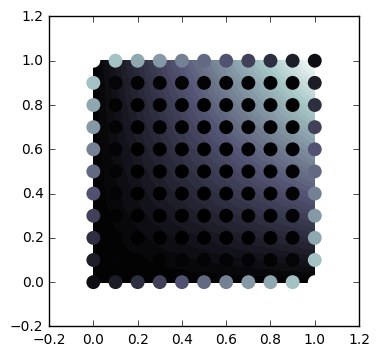

In [14]:
import matplotlib.pyplot as pl
%matplotlib inline

gdim = V.ufl_domain().geometric_dimension()  # OK to retrieve this so?
if gdim == 1:
    u = project(Expression("sqrt(x[0])*x[0]", degree=3), V)
    vals = u.compute_vertex_values(mesh)[:, None]
    coordinates = mesh.coordinates()
    errors = vals - np.sqrt(coordinates)*coordinates
    _ = pl.plot(coordinates, errors)
elif gdim == 2:
    u = project(Expression("x[0]*x[1]", degree=3), V)
    vals = u.compute_vertex_values(mesh)
    coordinates = mesh.coordinates()
    errors = vals - coordinates.T[0] * coordinates.T[1]
    plot(u, cmap='bone')
    pl.scatter(coordinates.T[0], coordinates.T[1], c=errors, s=100, cmap='bone', linewidths=0)
    pl.axes().set_aspect('equal')
print("Total error: %.3g" % np.linalg.norm(errors))

In [15]:
v = grad(Expression("x[0]", degree=3, domain=u.ufl_domain()))

--- Instant: compiling ---


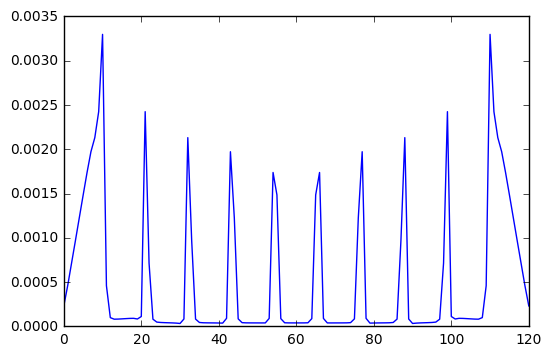

In [16]:
_ = pl.plot(errors)

However projection of arbitrary expressions requires some attention. ~~For instance we cannot use the following syntax to create them (dolfin seems to think we have an "enriched" element. Is this the case?)~~ (seems fixed now)

In [17]:
f = Expression("x[0]*x[0] + x[1]*x[1]", element=V.ufl_element())
u = project(f, V)
dolfin.plot(u, cmap='bone')

--- Instant: compiling ---


Calling FFC just-in-time (JIT) compiler, this may take some time.
  MBD: Assuming all mappings to be hermite in _get_auxiliary_variables()
  MBD: implement/check hermite trafo in quadraturetransformer.py
  MBD: Assuming all mappings to be hermite in _get_auxiliary_variables()
Transformation is not supported: 'hermite'


RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to perform just-in-time compilation of form.
*** Reason:  ffc.jit failed with message:
Traceback (most recent call last):
  File "/home/fenics/local/lib/python2.7/site-packages/dolfin/compilemodules/jit.py", line 128, in jit
    result = ffc.jit(ufl_object, parameters=p)
  File "/home/fenics/local/lib/python2.7/site-packages/ffc/jitcompiler.py", line 198, in jit
    module = jit_build(ufl_object, module_name, parameters)
  File "/home/fenics/local/lib/python2.7/site-packages/ffc/jitcompiler.py", line 120, in jit_build
    generate=jit_generate)
  File "/home/fenics/local/lib/python2.7/site-packages/dijitso/jit.py", line 160, in jit
    header, source, dependencies = generate(jitable, name, signature, params["generator"])
  File "/home/fenics/local/lib/python2.7/site-packages/ffc/jitcompiler.py", line 66, in jit_generate
    prefix=module_name, parameters=parameters, jit=True)
  File "/home/fenics/local/lib/python2.7/site-packages/ffc/compiler.py", line 141, in compile_form
    prefix, parameters, jit)
  File "/home/fenics/local/lib/python2.7/site-packages/ffc/compiler.py", line 188, in compile_ufl_objects
    ir = compute_ir(analysis, prefix, parameters, jit)
  File "/home/fenics/local/lib/python2.7/site-packages/ffc/representation.py", line 190, in compute_ir
    for (form_id, fd) in enumerate(form_datas)]
  File "/home/fenics/local/lib/python2.7/site-packages/ffc/representation.py", line 453, in _compute_integral_ir
    parameters)
  File "/home/fenics/local/lib/python2.7/site-packages/ffc/quadrature/quadraturerepresentation.py", line 101, in compute_integral_ir
    cell)
  File "/home/fenics/local/lib/python2.7/site-packages/ffc/quadrature/quadraturerepresentation.py", line 176, in _transform_integrals_by_type
    terms = _transform_integrals(transformer, integrals_dict, integral_type)
  File "/home/fenics/local/lib/python2.7/site-packages/ffc/quadrature/quadraturerepresentation.py", line 223, in _transform_integrals
    terms = transformer.generate_terms(integral.integrand(), integral_type)
  File "/home/fenics/local/lib/python2.7/site-packages/ffc/quadrature/quadraturetransformerbase.py", line 763, in generate_terms
    terms = self.visit(integrand)
  File "/home/fenics/local/lib/python2.7/site-packages/ufl/algorithms/transformer.py", line 104, in visit
    r = h(o, *[self.visit(op) for op in o.ufl_operands])
  File "/home/fenics/local/lib/python2.7/site-packages/ufl/algorithms/transformer.py", line 108, in visit
    r = h(o)
  File "/home/fenics/local/lib/python2.7/site-packages/ffc/quadrature/quadraturetransformerbase.py", line 480, in coefficient
    self.gdim, self.avg)}
  File "/home/fenics/local/lib/python2.7/site-packages/ffc/quadrature/quadraturetransformer.py", line 771, in create_function
    error("Transformation is not supported: " + repr(transformation))
  File "<string>", line 1, in <lambda>
  File "/home/fenics/local/lib/python2.7/site-packages/ufl/log.py", line 171, in error
    raise self._exception_type(self._format_raw(*message))
Exception: Transformation is not supported: 'hermite'
.
*** Where:   This error was encountered inside jit.py.
*** Process: 0
*** 
*** DOLFIN version: 2017.1.0.dev0
*** Git changeset:  8d4c7c807451f2301020ec23a2106f0501c632e3
*** -------------------------------------------------------------------------


We can do the following:

In [ ]:
f = Expression("x[0]*x[0] + x[1]*x[1]", degree=3)
u = project(f, V)
dolfin.plot(u, cmap='bone')

Another example:

In [ ]:
f = Expression("pow(x[0], 0.25)", degree=3)
u = project(f, V)
_ = plot(u, cmap='bone')

In [ ]:
# These three are for the triangle {(-1,-1), (1,-1), (-1,1)}
phi1 = Expression("(7/8)*x[0] + (7/8)*x[1] + (13/8)*x[0]*x[0] + (13/4)*x[0]*x[1]"
                  "+ (13/8)*x[1]*x[1] + (1/4)*x[0]*x[0]*x[0] + (13/8)*x[0]*x[0]*x[1]"
                  "+ (13/8)*x[0]*x[1]*x[1] + (1/4)*x[1]*x[1]*x[1]", degree=3)
phi2 = Expression("1/2 + (13/8)*x[0] + (7/8)*x[1] + (7/8)*x[0]*x[0] + (7/4)*x[0]*x[1]"
                  "+ (7/8)*x[1]*x[1] - (1/4)*x[0]*x[0]*x[0] + (7/8)*x[0]*x[0]*x[1]"
                  "+ (7/8)*x[0]*x[1]*x[1]", degree=3)
phi3 = Expression("1/2 + (7/8)*x[0] + (13/8)*x[1] + (7/8)*x[0]*x[0] + (7/4)*x[0]*x[1]"
                  "+ (7/8)*x[1]*x[1] + (7/8)*x[0]*x[0]*x[1] + (7/8)*x[0]*x[1]*x[1]"
                  "- (1/4)*x[1]*x[1]*x[1]",
                 degree=3)

#mesh = refine(refine(refine(refine(UnitTriangleMesh()))))
#elem = ufl.FiniteElement('Hermite', mesh.ufl_cell(), 3)
#W = FunctionSpace(mesh, elem)

v = project(phi3*phi1, V)
_ = plot(v, cmap='bone')

We also can~~not~~ interpolate:

In [ ]:
#mesh = UnitSquareMesh(10,10)
#V = FunctionSpace(mesh, 'P', 3)
#f = phi1 - phi2
v = interpolate(phi3, V)
_ = plot(v, cmap='bone')

### Comparison to Lagrange elements

We project the same function onto P3:

In [ ]:
W = FunctionSpace(mesh, 'P', 3)
f = Expression("x[0]*x[0] + x[1]*x[1]", degree=3)
u = project(f, W)
_ = plot(u, cmap='bone')

The constant function looks much worse:

In [ ]:
u = project(Constant(2.0), W)
_ = plot(u, cmap='bone')

## Extracting the nodal values

See section 5.2.6 of the tutorial.

In [ ]:
f = Expression("x[0]*x[0] + x[1]*x[1]", degree=3)
u = project(f, V)

vals = u.compute_vertex_values(mesh)
coordinates = mesh.coordinates()

import matplotlib.pyplot as pl
pl.scatter(coordinates.T[0], coordinates.T[1], c=vals, s=100, cmap='bone', linewidths=0)
_ = pl.axes().set_aspect('equal')

# Test construction of polynomial set

This is taken from the constructor of `FIAT.finite_element.FiniteElement()`.

**TODO:** I'd like to test whether the coefficients for the nodal basis functions agree with what I should be getting. 

In [ ]:
# build generalized Vandermonde matrix
from FIAT import polynomial_set, reference_element, hermite
K = reference_element.ReferenceElement(shape = reference_element.LINE,
                                       vertices = ((-1.0,),(1.0,)),
                                       topology = reference_element.UFCInterval().get_topology())
poly_set = polynomial_set.ONPolynomialSet(K, 3)
old_coeffs = poly_set.get_coeffs()
dual = hermite.CubicHermiteDualSet(K)
dualmat = dual.to_riesz(poly_set)

shp = dualmat.shape
if len(shp) > 2:
    num_cols = np.prod(shp[1:])

    A = np.reshape(dualmat, (dualmat.shape[0], num_cols))
    B = np.reshape(old_coeffs, (old_coeffs.shape[0], num_cols))
else:
    A = dualmat
    B = old_coeffs

V = np.dot(A, np.transpose(B))

Vinv = np.linalg.inv(V)

new_coeffs_flat = np.dot(np.transpose(Vinv), B)

new_shp = tuple([new_coeffs_flat.shape[0]] + list(shp[1:]))
new_coeffs = np.reshape(new_coeffs_flat, new_shp)

#poly_set = PolynomialSet(K, poly_set.get_degree(), poly_set.get_embedded_degree(),
#                         poly_set.get_expansion_set(), new_coeffs, poly_set.get_dmats())

In [ ]:
H = hermite.CubicHermite(K)
np.round(H.poly_set.tabulate_new(K.get_vertices()),2)

# Test transformation of basis functions

This is copied from `transform_hermite.py`, in a previous release of FIAT. It tests whether the nodal basis evaluated on a lattice over the reference element and over a transformed  element transforms well under an affine mapping.

Basically, what we do is we compute the "hermite" transformation in `evaluatebasis.py` by hand:

1. Tabulate (compute) the values of each basis function of the reference element over a lattice of points in the triangle, then multiply it by an adequate transformation matrix (mixing the values for the nodal basis functions related to derivatives).
2. Tabulate the values of each basis function defined over a different simplex.
3. Compare both results

In [ ]:
from FIAT import reference_element, hermite
from __future__ import print_function

# Let's set up the reference triangle and another one
Khat = reference_element.UFCTriangle()
K = reference_element.ReferenceElement(shape = reference_element.TRIANGLE,
                                       vertices = ((-1.0,-1.0),(1.0,-1.0),(-1.0,1.0)),
                                       topology = Khat.get_topology())

# Construct the affine mapping between them
A, b = reference_element.make_affine_mapping(K.get_vertices(), Khat.get_vertices())

# build the Hermite element on the two triangles
Hhat = hermite.CubicHermite(Khat)
H = hermite.CubicHermite(K)

# get some points on each triangle
pts_hat = Khat.make_lattice(6)
pts = K.make_lattice(6)

# as a sanity check on the affine mapping, make sure pts map to pts_hat
for i, p in enumerate(pts):
    if not np.allclose(pts_hat[i], np.dot(A, p) + b):
        print("barf")

In [ ]:
# Tabulate the Hermite basis on each triangle
# Each column is the value of one nodal basis function evaluated at every point
Hhat_tabulated = Hhat.get_nodal_basis().tabulate_new(pts_hat)
H_tabulated = H.get_nodal_basis().tabulate_new(pts)

### Prepare global transformation matrix
M = np.zeros((10,10), dtype=np.double)
Ainv = np.linalg.inv(A)

# Point values are transformed as is
# Derivative values are "mixed" with the Jacobian.
M[0,0] = 1.0
M[3,3] = 1.0
M[6,6] = 1.0
M[9,9] = 1.0
M[1:3,1:3] = np.transpose(Ainv)
M[4:6,4:6] = np.transpose(Ainv)
M[7:9,7:9] = np.transpose(Ainv)

print(np.allclose(H_tabulated, np.dot(M.T, Hhat_tabulated)))

In [ ]:
Hhat_tabulated.shape

In [ ]:
basis = H.get_nodal_basis()
basis.tabulate_new([(-1,-1),(-1,0),(0,0)])

## What are dmats ("expansion coefficients for basis function derivative") ?

In [ ]:
from FIAT import lagrange
Hhat = lagrange.Lagrange(Khat, 1)
basis = Hhat.get_nodal_basis()
dmats = basis.get_dmats()
print(len(dmats), dmats[0].shape, dmats[1].shape)
print(np.round(dmats[0], 1))
print(np.round(dmats[1], 1))